In [7]:
import os
import itertools
import warnings
from datetime import datetime as dt

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from astropy.timeseries import LombScargle
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
from pmdarima.arima import auto_arima

from ruptures import Pelt
from scipy.signal import welch
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss

import ipywidgets as widgets
import ruptures as rpt

%matplotlib inline

warnings.filterwarnings("ignore")

Data prep functions

In [8]:
def generate_data_summary(raw_df):
    # Generate a summary for the raw data
    summary = raw_df.describe(include='all')
    summary.loc['type'] = raw_df.dtypes
    summary.loc['median'] = (raw_df.median() * 10000 // 100 / 100)
    summary.loc['mean'] = (raw_df.mean() * 10000 // 100 / 100)
    summary.loc['mode'] = raw_df.mode().iloc[0]
    summary.loc['missing'] = ((100.0 * raw_df.isna().sum() / len(raw_df)).round(2).astype(str) + '%')
    summary.loc['unique'] = raw_df.nunique()
    summary.loc['min'] = raw_df.min()
    summary.loc['max'] = raw_df.max()

    columns_order = ['type', 'count', 'missing', 'unique', 'min', '25%', '50%', '75%', 'max', 'mean', 'median', 'std', 'mode']
    summary = summary.loc[columns_order].round(2)
    return summary

def find_missing_ranges(series):
    # Find the ranges of missing values in the series
    is_missing = series.isna()
    changes = is_missing.ne(is_missing.shift()).cumsum()
    missing_ranges = is_missing.groupby(changes).apply(lambda x: (x.index[0], x.index[-1]))
    return missing_ranges

def plot_time_series(ts1, ts2, ts1_label='Time Series 1', ts2_label='Time Series 2', figsize=(12, 10)):
    # Plot two time series on separate subplots
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize)

    # Plot the first time series
    axes[0].plot(ts1)
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Price')
    axes[0].set_title(ts1_label)

    # Plot the second time series
    axes[1].plot(ts2)
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Price')
    axes[1].set_title(ts2_label)

    # Show the plots
    plt.show()
    save_plot('ts1_ts2', f'Series Plots')  
    
def save_plot(title, plot_name, fig=None):
    if not fig:
        fig = plt.gcf()

    # Create the EDA directory if it doesn't exist
    if not os.path.exists('Pre_processing'):
        os.makedirs('Pre_processing')

    # Create the subdirectory for the series if it doesn't exist
    series_path = f'Pre_processing/{title}'
    if not os.path.exists(series_path):
        os.makedirs(series_path)

    # Save the plot in the corresponding subdirectory with the plot_name in the file name
    fig.savefig(f'{series_path}/{plot_name}.png')
    plt.close()


In [9]:
def count_missing_values(series):
    return series.isna().sum()

def max_missing_range(series):
    mask = series.isna()
    changes = mask.ne(mask.shift()).cumsum()
    counts = mask.groupby(changes).sum()
    counts = counts[counts > 1]
    return 0 if counts.empty else counts.max()

# def impute_missing_values(series, window):
#     if series.isnull().any():
#         rolling_mean = series.rolling(window=window, min_periods=1).mean()
#         return series.fillna(rolling_mean)
#     return series

def intervals_to_days(intervals):
    minutes = intervals * 2
    hours = minutes / 60
    days = hours / 24
    return days

def count_days_frequency(series):
    series = series.dropna()
    day_of_week_series = pd.Series(series.index.dayofweek, index=series.index)
    day_counts = day_of_week_series.value_counts().sort_index()
    day_counts.index = pd.to_datetime(day_counts.index, unit='D', origin=pd.Timestamp('2000-01-03')).day_name()
    return day_counts

def plot_streak_histogram(ts, title):
    isnull = ts.isnull()
    groups = isnull.ne(isnull.shift()).cumsum()
    streak_lengths = isnull.groupby(groups).sum()

    bins = pd.cut(streak_lengths, bins=[0, 1, 2, 3, 4, 5, 10, 100, 1000, streak_lengths.max()],
                labels=[str(x*2) + ' mins' for x in range(1, 6)] + ['22 mins', '4 hours', '1.3 days', '4+ days'])
    plt.figure(figsize=(8, 7))
    # plot histogram of binned data
    ax = bins.value_counts().sort_index().plot(kind='bar', edgecolor='black')
    plt.title(title)
    # add values to bars
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    # show the plot
    save_plot(title, f'Missing Values Streaks Histogram_{title}')  

def calculate_time_gaps(ts):
    isnull = ts.isnull()
    groups = isnull.ne(isnull.shift()).cumsum()
    streak_lengths = isnull.groupby(groups).sum()
    time_gaps = pd.to_timedelta(streak_lengths[streak_lengths > 0] * 2, unit='m')
    return time_gaps

def time_gaps_stats(series):
    return (series.dt.total_seconds() / 60).describe()


In [10]:
def rolling_mean(series, window=120):
    # Check if there are any missing values in the input series
    if series.isnull().any():
        # Create a copy of the input series for imputation
        imputed_series = series.copy()
        
        # Identify non-missing value blocks in the input series
        non_missing_blocks = series.notna().astype(int).groupby(series.isna().astype(int).cumsum()).cumsum()

        # Iterate through each non-missing value block
        for _, block in non_missing_blocks.groupby(non_missing_blocks):
            start_idx = block.index[0]
            end_idx = block.index[-1] + pd.Timedelta(minutes=2)
            
            # Calculate rolling mean for the block
            rolling_mean_block = series[start_idx:end_idx].rolling(window=window, min_periods=1).mean()
            
            # Impute missing values in the block with rolling mean
            imputed_series[start_idx:end_idx] = series[start_idx:end_idx].fillna(rolling_mean_block)

        # Fill any remaining missing values using backfill method
        imputed_series.fillna(method='bfill', inplace=True)
    else:
        # If there are no missing values, return the original series
        imputed_series = series
    return imputed_series

def rolling_median(series, window=120):
    # Check if there are any missing values in the input series
    if series.isnull().any():
        # Create a copy of the input series for imputation
        imputed_series = series.copy()
        
        # Identify non-missing value blocks in the input series
        non_missing_blocks = series.notna().astype(int).groupby(series.isna().astype(int).cumsum()).cumsum()

        # Iterate through each non-missing value block
        for _, block in non_missing_blocks.groupby(non_missing_blocks):
            start_idx = block.index[0]
            end_idx = block.index[-1] + pd.Timedelta(minutes=2)
            
            # Calculate rolling mean for the block
            rolling_mean_block = series[start_idx:end_idx].rolling(window=window, min_periods=1).median()
            
            # Impute missing values in the block with rolling mean
            imputed_series[start_idx:end_idx] = series[start_idx:end_idx].fillna(rolling_mean_block)

        # Fill any remaining missing values using backfill method
        imputed_series.fillna(method='bfill', inplace=True)
    else:
        # If there are no missing values, return the original series
        imputed_series = series
    return imputed_series

def impute_missing_values_mean(data, short_gap_threshold=120, long_gap_threshold=2880):
    # Identify the size of missing value gaps in the input data
    missing_gaps = data.isna().astype(int).groupby(data.notna().astype(int).cumsum()).cumsum()

    # Impute missing values for short gaps
    data_short_gaps = data.copy()
    data_short_gaps[missing_gaps <= short_gap_threshold] = rolling_mean(data_short_gaps)

    # Impute missing values for long gaps
    data_long_gaps = data.copy()
    data_long_gaps[missing_gaps > short_gap_threshold] = rolling_mean(data_long_gaps, long_gap_threshold)

    # Combine the short and long gap imputed data
    data_imputed = data_short_gaps.combine_first(data_long_gaps)

    # Fill any remaining missing values using backfill and forward fill methods
    data_imputed.fillna(method='bfill', inplace=True)
    data_imputed.fillna(method='ffill', inplace=True)

    return data_imputed

def impute_missing_values_median(data, short_gap_threshold=120, long_gap_threshold=2880):
    # Identify the size of missing value gaps in the input data
    missing_gaps = data.isna().astype(int).groupby(data.notna().astype(int).cumsum()).cumsum()

    # Impute missing values for short gaps
    data_short_gaps = data.copy()
    data_short_gaps[missing_gaps <= short_gap_threshold] = rolling_median(data_short_gaps)

    # Impute missing values for long gaps
    data_long_gaps = data.copy()
    data_long_gaps[missing_gaps > short_gap_threshold] = rolling_median(data_long_gaps, long_gap_threshold)

    # Combine the short and long gap imputed data
    data_imputed = data_short_gaps.combine_first(data_long_gaps)

    # Fill any remaining missing values using backfill and forward fill methods
    data_imputed.fillna(method='bfill', inplace=True)
    data_imputed.fillna(method='ffill', inplace=True)

    return data_imputed

def impute_missing_values_lin(data, short_gap_threshold=120):
    # Identify the size of missing value gaps in the input data
    missing_gaps = data.isna().astype(int).groupby(data.notna().astype(int).cumsum()).cumsum()

    # Impute missing values for short gaps using linear interpolation
    data_short_gaps = data.copy()
    data_short_gaps[missing_gaps <= short_gap_threshold] = linear_interpolation(data_short_gaps)

    # Impute missing values for long gaps using linear interpolation
    data_long_gaps = data.copy()
    data_long_gaps[missing_gaps > short_gap_threshold] = linear_interpolation(data_long_gaps)

    # Combine the short and long gap imputed data
    data_imputed = data_short_gaps.combine_first(data_long_gaps)

    # Fill any remaining missing values using backfill and forward fill methods
    data_imputed.fillna(method='bfill', inplace=True)
    data_imputed.fillna(method='ffill', inplace=True)

    return data_imputed

def linear_interpolation(series):
    # Check if there are any missing values in the input series
    if series.isnull().any():
        # Create a copy of the input series for imputation
        imputed_series = series.copy()

        # Identify non-missing value blocks in the input series
        non_missing_blocks = series.notna().astype(int).groupby(series.isna().astype(int).cumsum()).cumsum()

        # Iterate through each non-missing value block
        for _, block in non_missing_blocks.groupby(non_missing_blocks):
            start_idx = block.index[0]
            end_idx = block.index[-1] + pd.Timedelta(minutes=2)

            # Impute missing values in the block using linear interpolation
            imputed_series[start_idx:end_idx] = series[start_idx:end_idx].interpolate(method='linear')

        # Fill any remaining missing values using backfill method
        imputed_series.fillna(method='bfill', inplace=True)
    else:
        # If there are no missing values, return the original series
        imputed_series = series
    return imputed_series

In [11]:
def load_data(filename):
    raw_df = pd.read_csv(filename, header=None)
    raw_df.columns = ['datetime', 'ts1', 'ts2']
    raw_df['datetime'] = pd.to_datetime(raw_df['datetime']-719529,unit='d').round('s')
    raw_df.set_index('datetime', inplace=True)
    return raw_df

def generate_data_summary(df):
    print(df.describe())

def analyze_time_gaps(df):
    time_gaps = df.index.to_series().diff().dropna()
    time_gap_stats = time_gaps.describe()
    print('Time gaps:\n')
    print(time_gap_stats)
    outlier_threshold = pd.Timedelta(minutes=10)
    outliers = time_gaps[time_gaps > outlier_threshold]
    plt.hist(time_gaps.dt.total_seconds() / 60, bins=50)
    plt.xlabel('Time Gap (minutes)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Time Gaps')
    plt.show()
    
def remove_weekends(df):
    """Remove rows corresponding to weekends (Saturday and Sunday) from the DataFrame"""
    return df[df.index.dayofweek != 5]

def time_gaps_stats(s):
    """Return summary statistics for a Series of time gaps"""
    return s.describe()
def count_days_frequency_resampled(ts):
    day_counts = count_days_frequency(ts.resample('D').mean())
    return day_counts

In [12]:
# def impute_saturdays(series):
#     # Create a copy of the series to avoid modifying the original dataset
#     filled_series = series.copy()
    
#     # Find the indices of Saturdays
#     saturday_indices = filled_series.index[filled_series.index.weekday == 5]
    
#     # Forward fill NaNs on Saturdays
#     for idx in saturday_indices:
#         if pd.isna(filled_series.loc[idx]):
#             # Get the previous value if it exists, otherwise use the next valid value
#             previous_value = filled_series.loc[:idx].ffill().iloc[-1]
#             filled_series.loc[idx] = previous_value
            
#     # Backfill NaNs on Saturdays
#     for idx in saturday_indices:
#         if pd.isna(filled_series.loc[idx]):
#             # Get the next value if it exists, otherwise use the previous valid value
#             next_value = filled_series.loc[idx:].bfill().iloc[0]
#             filled_series.loc[idx] = next_value
            
#     return filled_series

# def exponential_smoothing_imputation(data, smoothing_level=0.6):
#     model = SimpleExpSmoothing(data)
#     fitted_model = model.fit(smoothing_level=smoothing_level, optimized=False)
#     return fitted_model.fittedvalues

# def moving_average_imputation(data, window_size=3):
#     return data.rolling(window=window_size, min_periods=1, center=True).mean()

# def evaluate_imputation_method(data, imputation_function, missing_rate=0.1, random_seed=42):
#     np.random.seed(random_seed)
#     data_with_artificial_missing_values = data.copy()
#     mask = np.random.rand(len(data)) < missing_rate
#     data_with_artificial_missing_values[mask] = np.nan

#     imputed_data = imputation_function(data_with_artificial_missing_values)
#     mse = mean_squared_error(data[~mask], imputed_data[~mask])
#     print("Mean Squared Error:", mse)



In [13]:
def data_pre_process(raw_df):
    # Generate data summary
    generate_data_summary(raw_df)

    # Define the time series
    ts1 = raw_df['ts1']
    ts2 = raw_df['ts2']

    # Analyze missing values and missing ranges
    analyze_missing_values(ts1, "ts1")
    analyze_missing_values(ts2, "ts2")

    # Analyze time gaps
    analyze_time_gaps(raw_df)

    # Count days frequency
    day_counts_ts1 = count_days_frequency_resampled(ts1)
    print(day_counts_ts1)

    day_counts_ts2 = count_days_frequency_resampled(ts2)
    print(day_counts_ts2)

    # Analyze missing values and missing ranges for non-smoothed data
    ts_1_ns = raw_df_ns['ts1']
    ts_2_ns = raw_df_ns['ts2']
    analyze_missing_values(ts1, "ts1")
    analyze_missing_values(ts2, "ts2")

    # Plot the histogram of missing value streaks for ts1_ns and ts2_ns
    plot_streak_histogram(ts1, 'ts1')
    plot_streak_histogram(ts2, 'ts2')

    # Analyze time gaps for non-smoothed data
    time_gaps_1 = calculate_time_gaps(ts1)
    print(time_gaps_stats(time_gaps_1))
    time_gaps_2 = calculate_time_gaps(ts2)
    print(time_gaps_stats(time_gaps_2))


def analyze_missing_values(ts, ts_name):
    missing_ts = count_missing_values(ts)
    print(f"Missing values in {ts_name}: {missing_ts}")

    max_ts = max_missing_range(ts)
    print(f"Max missing range in {ts_name}: {max_ts}")

    days_ts = intervals_to_days(max_ts)
    print(f"Max missing range in {ts_name}: {days_ts:.2f} days")


def analyze_time_gaps(df):
    time_gaps = df.index.to_series().diff().dropna()
    time_gap_stats = time_gaps.describe()
    print('Time gaps:\n')
    print(time_gap_stats)
    # plot_time_gaps_histogram(time_gaps)


def plot_time_gaps_histogram(time_gaps):
    outlier_threshold = pd.Timedelta(minutes=10)
    outliers = time_gaps[time_gaps > outlier_threshold]
    plt.hist(time_gaps.dt.total_seconds() / 60, bins=50)
    plt.xlabel('Time Gap (minutes)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Time Gaps')
    plt.show()


def count_days_frequency_resampled(ts):
    return count_days_frequency(ts.resample('D').mean())


In [14]:
def process_and_plot_time_series(raw_df, ts1_label='ts1', ts2_label='ts2', method='interpolate'):
    # Extract time series from the raw DataFrame
    ts1 = raw_df[ts1_label]
    ts2 = raw_df[ts2_label]

    # Plot the original time series
    plot_time_series(ts1, ts2, ts1_label, ts2_label)

    # Calculate maximum missing ranges for each time series
    max_ts1 = max_missing_range(ts1)
    max_ts2 = max_missing_range(ts2)

    if method == 'interpolate':
        # Impute missing values in ts1 and ts2 using linear interpolation
        imputed_ts1 = impute_missing_values_lin(ts1)
        imputed_ts2 = impute_missing_values_lin(ts2)
    elif method == 'mean':    
        # Impute missing values in ts1 and ts2 using their respective maximum missing ranges
        imputed_ts1 = impute_missing_values_mean(ts1, long_gap_threshold=max_ts1)
        imputed_ts2 = impute_missing_values_mean(ts2, long_gap_threshold=max_ts2)
    elif method == 'median':
        # Impute missing values in ts1 and ts2 using their respective maximum missing ranges
        imputed_ts1 = impute_missing_values_median(ts1, long_gap_threshold=max_ts1)
        imputed_ts2 = impute_missing_values_median(ts2, long_gap_threshold=max_ts2)

    # Print the number of missing values in the imputed series
    print(f"Missing values in imputed {ts1_label}: {imputed_ts1.isna().sum()}")
    print(f"Missing values in imputed {ts2_label}: {imputed_ts2.isna().sum()}")

    # Calculate the maximum missing range in the imputed series
    max_imputed_ts1 = max_missing_range(imputed_ts1)
    max_imputed_ts2 = max_missing_range(imputed_ts2)

    # Print the maximum missing range in the imputed series
    print(f"Max missing range in imputed {ts1_label}: {max_imputed_ts1}")
    print(f"Max missing range in imputed {ts2_label}: {max_imputed_ts2}")

    # Plot the imputed time series
    plot_time_series(imputed_ts1, imputed_ts2, f"Imputed {ts1_label}", f"Imputed {ts2_label}")
    clean_df =  pd.concat([imputed_ts1, imputed_ts2], axis=1)
    return clean_df

Main section

In [15]:
# Load the data
filename = "Test_data.csv"
raw_df = load_data(filename)
raw_df.to_csv('raw_df.csv')
# Perform the analysis excluding saturdays
raw_df_ns = raw_df.copy()
raw_df_ns = raw_df_ns[raw_df_ns.index.dayofweek != 5]  # 5 represents Saturday
# Run the main function
data_pre_process(raw_df) 
data_pre_process(raw_df_ns)
#impute missing values
imputation_methods = ['interpolate', 'mean', 'median']
for method in imputation_methods:
    clean_df = process_and_plot_time_series(raw_df, ts1_label='ts1', ts2_label='ts2', method=method)
    clean_df.to_csv(f'{method}_clean_df.csv')


                 ts1            ts2
count  201517.000000  936488.000000
mean       95.172272       0.927215
std         1.282164       0.119920
min        91.512942       0.601150
25%        95.106221       0.871450
50%        95.462056       0.945000
75%        96.042938       1.027800
max        96.852863       1.108050
Missing values in ts1: 1113924
Max missing range in ts1: 3579
Max missing range in ts1: 4.97 days
Missing values in ts2: 378953
Max missing range in ts2: 2139
Max missing range in ts2: 2.97 days
Time gaps:

count            1315440
mean     0 days 00:02:00
std      0 days 00:00:00
min      0 days 00:02:00
25%      0 days 00:02:00
50%      0 days 00:02:00
75%      0 days 00:02:00
max      0 days 00:02:00
Name: datetime, dtype: object
Monday       258
Tuesday      259
Wednesday    261
Thursday     260
Friday       253
Sunday       243
Name: datetime, dtype: int64
Monday       261
Tuesday      262
Wednesday    261
Thursday     261
Friday       260
Sunday       259
Name: 

KeyboardInterrupt: 

In [19]:
filename = "Test_data.csv"
raw_df = load_data(filename)
ts1 = raw_df['ts1']
ts2 = raw_df['ts2']

imputed_ts1 = impute_missing_values(ts1, short_gap_threshold=120, long_gap_threshold=2880)

In [48]:
imputed_ts2 = impute_missing_values(ts2, short_gap_threshold=120, long_gap_threshold=2880)

In [50]:
clean_df =  pd.concat([imputed_ts1, imputed_ts2], axis=1)
clean_df.to_csv(f'{method}_clean_df.csv')

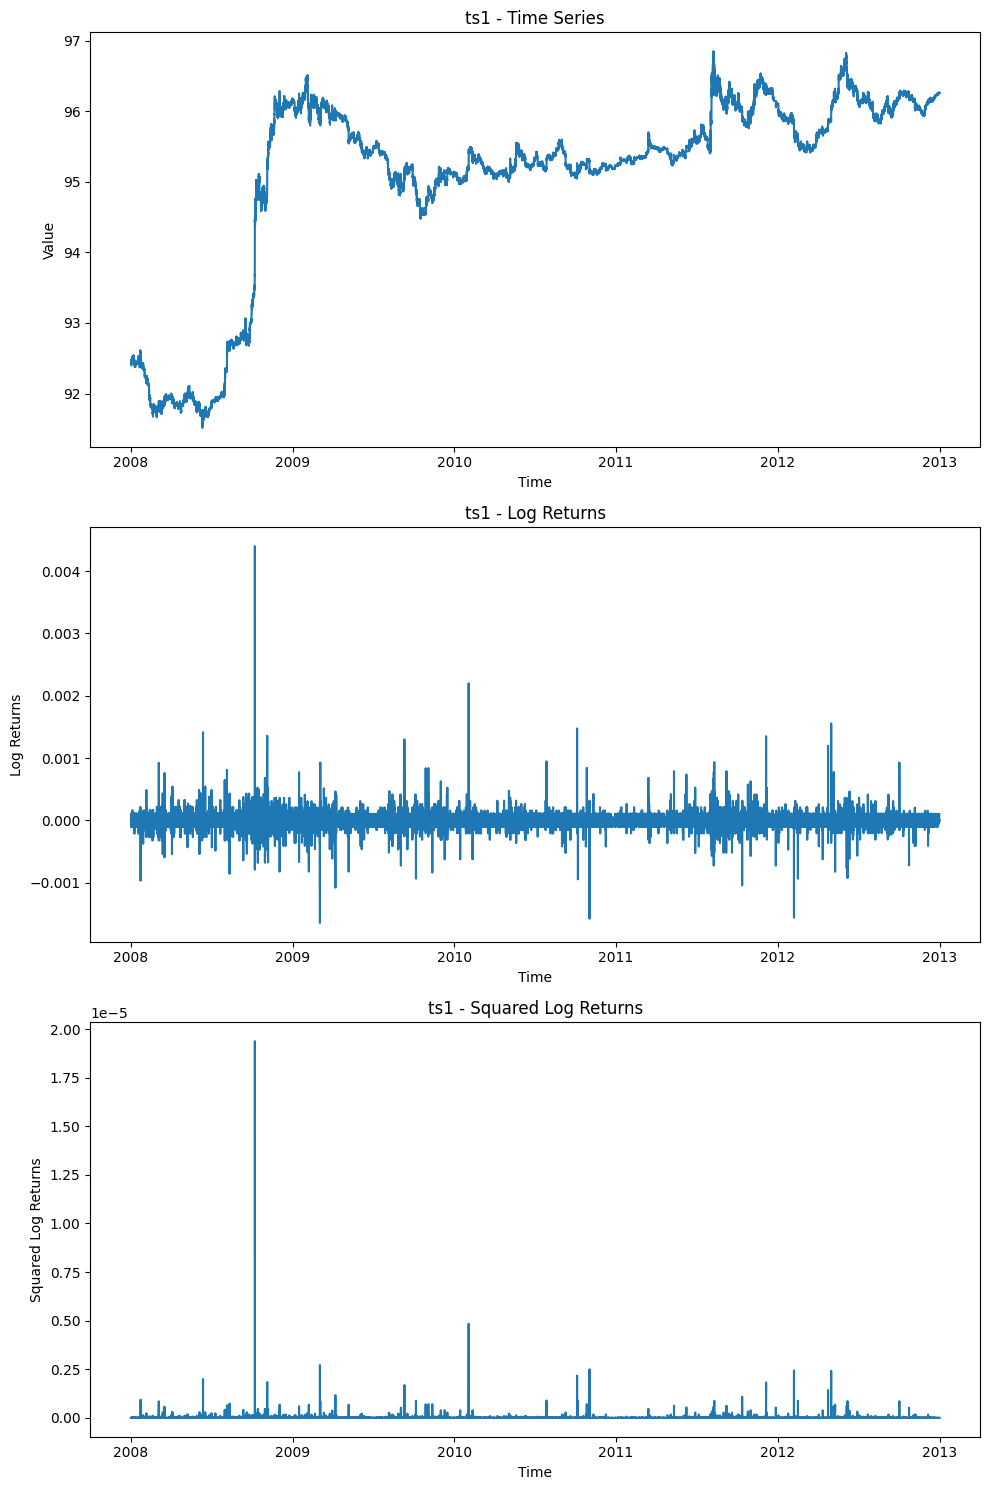

In [21]:
def calculate_log_returns(df):
    rt = np.log(df / df.shift(1))
    rt.dropna(inplace=True)
    return rt

def plot_series_and_returns(ts, title):
    # Calculate log returns and squared log returns
    returns = calculate_log_returns(ts)
    squared_log_returns = returns**2

    # Create subplots
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

    # Plot time series
    axes[0].plot(ts)
    axes[0].set_title(f'{title} - Time Series')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Value')

    # Plot log returns
    axes[1].plot(returns)
    axes[1].set_title(f'{title} - Log Returns')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Log Returns')

    # Plot squared log returns
    axes[2].plot(squared_log_returns)
    axes[2].set_title(f'{title} - Squared Log Returns')
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('Squared Log Returns')

    # Adjust layout and display plot
    plt.tight_layout()
    # save_plot(title, f'Series Plots_{title}')  
    plt.show()
plot_series_and_returns(imputed_ts1, 'ts1')

In [3]:
!pip install pykalman

  Using cached pykalman-0.9.5.tar.gz (228 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48450 sha256=37e97dff0c12df4729507d05a14285971167d170530e6f35b03e0a8a58795a20
  Stored in directory: c:\users\jordan moshcovitis\appdata\local\pip\cache\wheels\41\7b\20\1ee01729015931cd6e1c1a4aad4c22a574991832c50c3f4b94
Successfully built pykalman


In [4]:
from pykalman import KalmanFilter

In [26]:
def impute_missing_data_kalman(data):
    # Replace missing values with NaN
    data = np.array(data)
    data[np.isnan(data)] = np.nan

    # Initialize the Kalman filter
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

    # Estimate the parameters using the EM algorithm
    kf = kf.em(data)

    # Impute missing values using the Kalman filter
    imputed_data, _ = kf.smooth(data)

    return imputed_data

In [21]:
filename = "Test_data.csv"
raw_df = load_data(filename)

In [22]:
ts1 = raw_df['ts1']
ts2 = raw_df['ts2']
ts1_d = ts1.resample('D').mean()

In [27]:
kal = impute_missing_data_kalman(ts1_d)

ValueError: object has no __init__ method

In [ ]:
ts1 = raw_df['ts1']
ts2 = raw_df['ts2']

plot_time_series(ts1, ts2, 'ts1', 'ts2')

# Impute missing values in ts1 and ts2 using their respective maximum missing ranges
imputed_ts1 = impute_missing_values(ts1,long_gap_threshold = max_ts1)
imputed_ts2 = impute_missing_values(ts2, long_gap_threshold = max_ts2)

# Print the number of missing values in the imputed series
print(f"Missing values in imputed ts1: {imputed_ts1.isna().sum()}")
print(f"Missing values in imputed ts2: {imputed_ts2.isna().sum()}")

# Calculate the maximum missing range in the imputed series
max_imputed_ts1 = max_missing_range(imputed_ts1)
max_imputed_ts2 = max_missing_range(imputed_ts2)

# Print the maximum missing range in the imputed series
print(f"Max missing range in imputed ts1: {max_imputed_ts1}")
print(f"Max missing range in imputed ts2: {max_imputed_ts2}")
#PLot original data
# plot_time_series(ts1, ts2)

# Plot the imputed time series
plot_time_series(imputed_ts1, imputed_ts2)

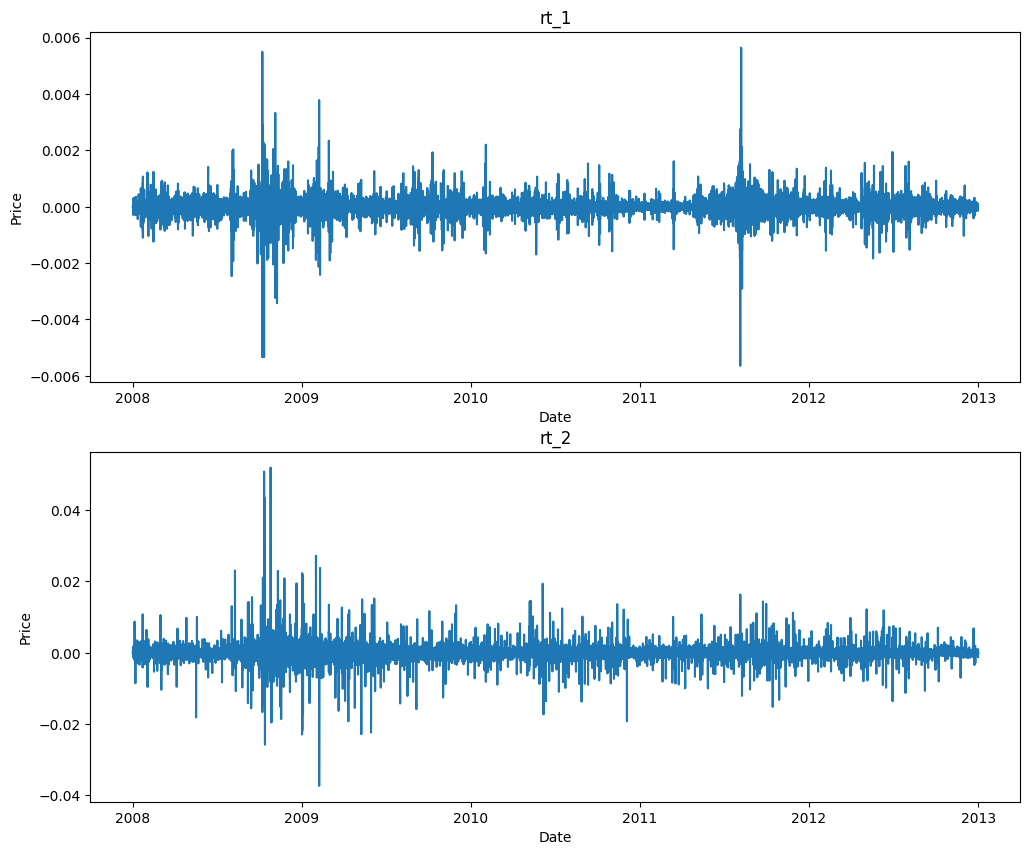

In [6]:
clean_df =  pd.concat([imputed_ts1, imputed_ts2], axis=1)
clean_df.to_csv('clean_df.csv')
# print(clean_df.isna().sum())
ts_1_imp = clean_df['ts1']
ts_2_imp = clean_df['ts2']
# def linear_interpolate_df(df):
#     df_interpolated = df.copy()
#     for col in df.columns:
#         df_interpolated[col] = df_interpolated[col].interpolate(method='linear')
#     return df_interpolated

# imp_df = raw_df.copy()
# for col in raw_df.columns:
#     print('1')
#     imp_col = impute_saturdays(imp_df[col])
#     print('2')
#     imp_df[col] = linear_interpolate_df(imp_col)
#     print(imp_df[col].isna().sum())


# rt = np.log(raw_df/raw_df.shift(1))
rt = np.log(clean_df/clean_df.shift(1))
rt.dropna(inplace=True)
rt_1 = rt['ts1']
rt_2 = rt['ts2']
plot_time_series(rt_1, rt_2, 'rt_1', 'rt_2')

In [ ]:
# # Load the data
# filename = "Test_data.csv"
# raw_df = load_data(filename)

# # Generate data summary
# generate_data_summary(raw_df)

# # Define the time series
# ts1 = raw_df['ts1']
# ts2 = raw_df['ts2']

# # Count missing values in ts1 and ts2
# missing_ts1 = count_missing_values(ts1)
# missing_ts2 = count_missing_values(ts2)
# print(f"Missing values in ts1: {missing_ts1}")
# print(f"Missing values in ts2: {missing_ts2}")

# # Get the maximum missing range in ts1 and ts2
# max_ts1 = max_missing_range(ts1)
# max_ts2 = max_missing_range(ts2)
# print(f"Max missing range in ts1: {max_ts1}")
# print(f"Max missing range in ts2: {max_ts2}")

# # Convert the maximum missing ranges to days
# days_ts1 = intervals_to_days(max_ts1)
# days_ts2 = intervals_to_days(max_ts2)
# print(f"Max missing range in ts1: {days_ts1:.2f} days")
# print(f"Max missing range in ts2: {days_ts2:.2f} days")

# # So min window size for any imputation/smoothing should be 5 days and 3 days respectively for ts1 and 2

# # Analyze time gaps
# analyze_time_gaps(raw_df)

# day_counts_ts1 = count_days_frequency_resampled(ts1)
# print(day_counts_ts1)

# day_counts_ts2 = count_days_frequency_resampled(ts2)
# print(day_counts_ts2)

# # Extract time series ts1_ns and ts2_ns from raw_df_ns
# ts_1_ns = raw_df_ns['ts1']
# ts_2_ns = raw_df_ns['ts2']
# # Count missing values in ts1 and ts2
# missing_ts1_ns = count_missing_values(ts_1_ns)
# missing_ts2_ns = count_missing_values(ts_2_ns)
# print(f"Missing values in ts1: {missing_ts1_ns}")
# print(f"Missing values in ts2: {missing_ts2_ns}")

# # Get the maximum missing range in ts1 and ts2
# max_ts1_ns = max_missing_range(ts_1_ns)
# max_ts2_ns = max_missing_range(ts_2_ns)
# print(f"Max missing range in ts1: {max_ts1_ns}")
# print(f"Max missing range in ts2: {max_ts2_ns}")

# # Convert the maximum missing ranges to days
# days_ts1_ns = intervals_to_days(max_ts1_ns)
# days_ts2_ns = intervals_to_days(max_ts2_ns)
# print(f"Max missing range in ts1: {days_ts1_ns:.2f} days")
# print(f"Max missing range in ts2: {days_ts2_ns:.2f} days")

# # Plot the histogram of missing value streaks for ts1_ns and ts2_ns
# plot_streak_histogram(ts1_ns, 'ts1')
# plot_streak_histogram(ts2_ns, 'ts2')


# # Call the function with the time_gaps variable
# time_gaps_1 = calculate_time_gaps(ts_1_ns)
# print(time_gaps_stats(time_gaps_1))
# time_gaps_2 = calculate_time_gaps(ts_2_ns)
# print(time_gaps_stats(time_gaps_2))

